In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import seaborn as sns
sns.set()
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from arch import arch_model
%matplotlib inline
import hmmlearn.hmm
from hmmlearn.hmm import GaussianHMM
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

# Часть 1

In [2]:
import re
w_a_p = []
text_list = []
text_with_no_space = []
with open('all_toms.txt', "w", encoding='utf-8') as all_toms:
    for x in range(1,5):
        file = open(f'tom_{x}.txt', encoding='utf-8')
        for  line in file :
            line = re.sub('[^а-яА-Я ]', '', line ).lower()
            line = re.sub('[ ]+', ' ', line )
            line = re.sub('[ ]+', ' ', line )
            if (line != " " and len(line) >= 1) or (line != '' and len(line) >= 1):
                if line[0] == " ":
                    w_a_p.append(line[1:])
                    all_toms.write(line + '\n')
                else: 
                    w_a_p.append(line)
                    all_toms.write(line + '\n')

        file.close()
all_toms.close()

for x in w_a_p:
    if x != '':
        text_list.append(x)


<ipython-input-3-c21bd818bcd0>:7: RuntimeWarning: invalid value encountered in true_divide
  probabilities = (probabilities / probabilities.sum(axis=1)[:, None])


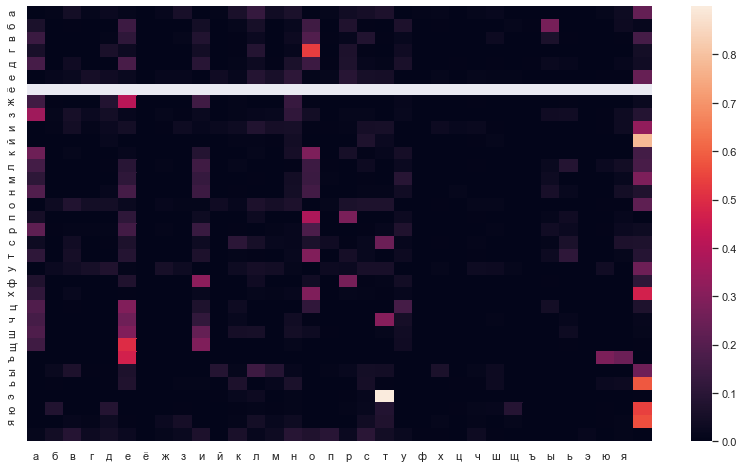

In [3]:
ru = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
text = ''.join(text_list)
POS = {l: i for i, l in enumerate(ru)}
probabilities = np.zeros((len(ru), len(ru)))
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])
df = pd.DataFrame(probabilities, index=(c for c in ru), columns=(c for c in ru))
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

# Что-то страшное, лучше не смотреть. Оставлю, если решу поподбирать пароли ))) 

start = POS['б']
word_dic = {}
prior = 1. / len(ru)
for a in ru:
    for b in ru:
        for c in ru:
            for d in ru:
                for e in ru:
                    for f in ru:
                        for g in ru:
                            for h in ru:
                                proba = prior * probabilities[start, POS[a]] * probabilities[POS[a], POS[b]] * probabilities[POS[b] , POS[c]] * probabilities[POS[c], POS[d]] * probabilities[POS[d], POS[e]] * probabilities[POS[e], POS[f]] * probabilities[POS[f],  POS[g]] * probabilities[POS[g], POS[h]]
                                if proba > 0:
                                    word_dic[''.join(['б', a, b ,c , d , f , g , h ])] = proba

In [4]:
VAR = 0
start = POS['п']
end = POS['р']
prior = 1. / len(ru)
for a in ru:
    for b in ru:
        proba = prior * probabilities[start, POS[a]] * probabilities[POS[a], POS[b]] * probabilities[POS[b], end]
        if proba > 0:
            VAR += proba
print(f'Вероятность встретить строку, начинающуюся на "п" и кончающуюся на "р" является около {VAR * 100} %')

Вероятность встретить строку, начинающуюся на "п" и кончающуюся на "р" является около 0.09600858896233166 %


# Тут возникла заминка, так как из-за включения пробeла в состав текста, то получившееся слово было некорректным.
### 1) потому что включало пробел ("св ти оря", "голой умо")
### 2) мы рассматривали строки, а не слова

## Потому я решил немного заморочиться и разбить текст на слова и уже потом попробовать сделать слово.

In [5]:
for _ in text_list: 
    _ = _.split()
    text_with_no_space += _
ru = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
text = ''.join(text_with_no_space)
POS = {l: i for i, l in enumerate(ru)}
probabilities = np.zeros((len(ru), len(ru)))
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])


<ipython-input-5-2a74c210115c>:10: RuntimeWarning: invalid value encountered in true_divide
  probabilities = (probabilities / probabilities.sum(axis=1)[:, None])


In [6]:
s = []
start = np.random.choice(list(ru))
s.append(start)
length = 7
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(ru), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

юилысашу


# Лучшие варианты) 
Помпово жетралее дполозал шномасто гогелсен пилилиеб грозинет


# Часть 2 

B:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


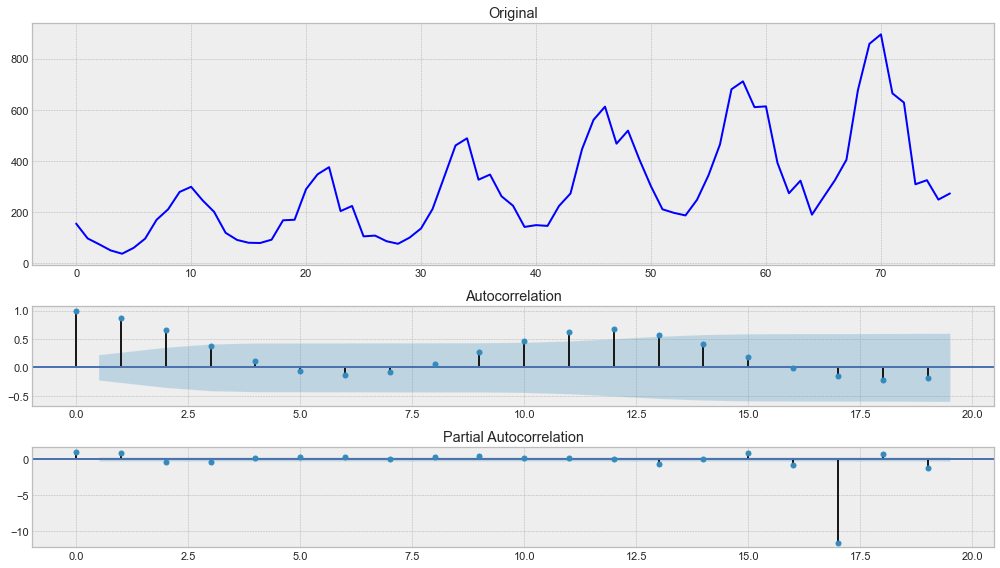

In [7]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
tsplot(sales_of_company_x['Count'])

In [8]:
values = sales_of_company_x['Count'].values.reshape(-1,1)

In [9]:
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -516.1188153076023
2 -487.4585983448758
3 -465.4758943249865
4 -454.54532730630297
5 -447.66570883789524
6 -436.42916202467717
7

Fitting a model with 79 free scalar parameters with only 77 data points will result in a degenerate solution.
Fitting a model with 98 free scalar parameters with only 77 data points will result in a degenerate solution.
Fitting a model with 119 free scalar parameters with only 77 data points will result in a degenerate solution.
Fitting a model with 142 free scalar parameters with only 77 data points will result in a degenerate solution.


 -433.3482805316872
8 -426.47821652281493
9 -420.04115048907374
10 -415.28204925826356


Fitting a model with 167 free scalar parameters with only 77 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 77 data points will result in a degenerate solution.


11 -411.6545514000069
12 -403.16294833502764
13 -397.56896562173046


Fitting a model with 119 free scalar parameters with only 77 data points will result in a degenerate solution.


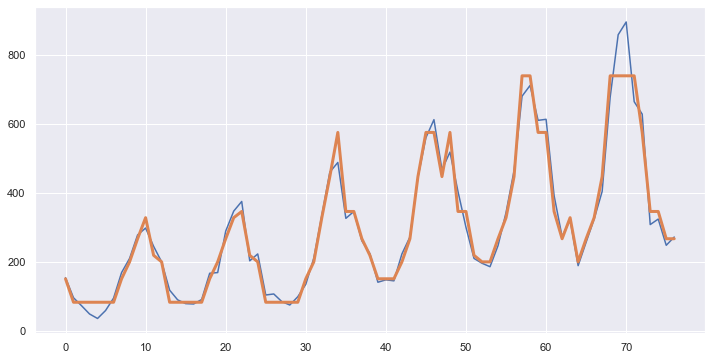

In [10]:
model = GaussianHMM(n_components=10,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

In [11]:
model.transmat_.shape

(10, 10)

# Спасибо за проверку!